In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
llna = pd.read_excel(raw_dir /'JRC.xlsx')

In [4]:
llna.shape

(222, 8)

In [5]:
llna.reaction_chemistry_domain.unique()

array(['MA', 'SB', 'Acyl', 'SN2', 'pro-SB', 'pre/pro-MA', 'pre-MA',
       'non-reactive', 'pro-MA', 'pre-MA_', 'non-reactive_SN2_',
       'SB_or_MA', 'SNAR', 'pro/pre-MA', 'Acyl_or_pre',
       'pro/pre-MA_or_SB', 'non-reactive_SB', 'non-reactive_MA',
       'pro-SN2_', 'pre', 'pre/pro-MA_or_pseudo_SB', 'pro-SN2',
       'pro/pre-SB', 'Special_case_', 'non-reactive_pro-SN2_(weak)',
       'pre/pro-(MA_or_SN2)/pre', 'SB_or_cross_linking', 'pro-SN2_or_pre',
       'Special_case', 'pre_', 'pro/pre', 'MA_or_Acyl', 'Pro/Pre-SB',
       'pre-SB', 'FP_in_LLNA', 'FP_in_LLNA_or_impurity', 'FP',
       'MA_or_SN1', 'non-reactive_'], dtype=object)

In [6]:
llna = (llna
 .assign(rxn = lambda x: x['reaction_chemistry_domain'].replace({'non-reactive_' :'non-reactive', 'pre_': 'pre', 'FP_in_LLNA': 'FP', 'FP_in_LLNA_or_impurity':'FP','Special_case_': 'Special_case',  'pre-MA_': 'pre_MA' ,\
  'non-reactive_SN2_' : 'non-reactive_SN2', 'pro-SN2_' : 'pro-SN2', 'Special_case_': 'Special_case' }))
 
 )

In [7]:
llna['SMILES'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 222 entries, 0 to 221
Series name: SMILES
Non-Null Count  Dtype 
--------------  ----- 
222 non-null    object
dtypes: object(1)
memory usage: 1.9+ KB


In [8]:
llna.to_csv(raw_dir/'llna_cleaned.csv')

In [9]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import grakel
import networkx as nx

MOLS = dict(zip(llna['DTXSID'], llna['SMILES']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,2048)) for i in MOLS.values()])
FP0.index = MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]

In [10]:
from scipy.spatial.distance import pdist, squareform

In [11]:
D_mgrn = pd.DataFrame(squareform(pdist(FP0, 'jaccard')), columns = FP0.index, index = FP0.index)

In [12]:
S_mgrn = 1-D_mgrn

In [13]:
S_mgrn.head()

,DTXSID1031626,DTXSID4051879,DTXSID00231670,DTXSID7049398,DTXSID7026235,DTXSID5032523,DTXSID8026515,DTXSID5021881,DTXSID4021137,DTXSID9021138,...,DTXSID90225265,DTXSID5021332,DTXSID5046512,DTXSID7026156,DTXSID5047035,DTXSID1041425,DTXSID8049416,DTXSID3037757,DTXSID0021969,DTXSID8021438
DTXSID1031626,1.000000,0.062500,0.265306,0.100000,0.153846,0.120000,0.043478,0.000000,0.108108,0.088235,...,0.175439,0.050000,0.025641,0.092593,0.058824,0.069767,0.219512,0.065217,0.160000,0.031250
DTXSID4051879,0.062500,1.000000,0.092593,0.083333,0.017857,0.019231,0.022727,0.035714,0.000000,0.000000,...,0.015873,0.026316,0.027778,0.056604,0.275000,0.228571,0.021739,0.314286,0.078431,0.000000
DTXSID00231670,0.265306,0.092593,1.000000,0.086207,0.096774,0.066667,0.037037,0.025641,0.065217,0.071429,...,0.102941,0.041667,0.043478,0.080645,0.087719,0.102041,0.094340,0.075472,0.222222,0.025000
DTXSID7049398,0.100000,0.083333,0.086207,1.000000,0.070175,0.075472,0.088889,0.000000,0.050000,0.055556,...,0.046154,0.023810,0.000000,0.111111,0.078431,0.119048,0.085106,0.063830,0.134615,0.000000
DTXSID7026235,0.153846,0.017857,0.096774,0.070175,1.000000,0.107143,0.102041,0.000000,0.119048,0.075000,...,0.123077,0.021277,0.022222,0.083333,0.034483,0.019608,0.166667,0.018519,0.103448,0.026316


<Axes: >

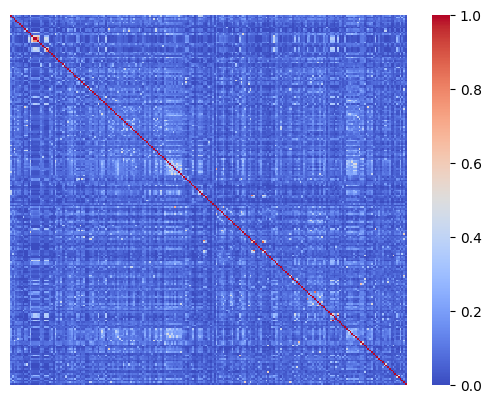

In [14]:
sns.heatmap(S_mgrn, cmap = 'coolwarm',xticklabels=False, yticklabels=False)

In [15]:
llna.rxn.unique()

array(['MA', 'SB', 'Acyl', 'SN2', 'pro-SB', 'pre/pro-MA', 'pre-MA',
       'non-reactive', 'pro-MA', 'pre_MA', 'non-reactive_SN2', 'SB_or_MA',
       'SNAR', 'pro/pre-MA', 'Acyl_or_pre', 'pro/pre-MA_or_SB',
       'non-reactive_SB', 'non-reactive_MA', 'pro-SN2', 'pre',
       'pre/pro-MA_or_pseudo_SB', 'pro/pre-SB', 'Special_case',
       'non-reactive_pro-SN2_(weak)', 'pre/pro-(MA_or_SN2)/pre',
       'SB_or_cross_linking', 'pro-SN2_or_pre', 'pro/pre', 'MA_or_Acyl',
       'Pro/Pre-SB', 'pre-SB', 'FP', 'MA_or_SN1'], dtype=object)

In [16]:
rxn_domains = {k: group['DTXSID'].tolist() for k, group in llna.groupby('rxn') if len(group['DTXSID'].tolist()) >5}

In [17]:
rxn_domains.keys()

dict_keys(['Acyl', 'MA', 'SB', 'SN2', 'SNAR', 'non-reactive', 'pre', 'pre-MA', 'pro-MA'])

In [18]:
print(f" max {max(S_mgrn.describe().loc['50%'])}, min {min(S_mgrn.describe().loc['50%'])}")

 max 0.125, min 0.021507863089731738


<Axes: >

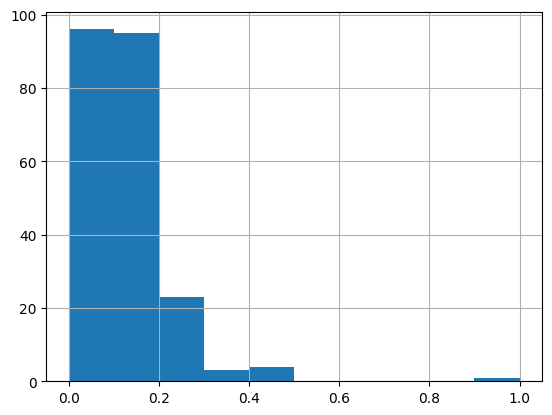

In [52]:
S_mgrn.DTXSID1031626.hist()

In [120]:
def transform_matrix(df):
    a = df.where(np.triu(np.ones(df.shape)).astype('bool'))
    a = df.stack().reset_index()
    a = a.where(a.iloc[:,0] != a.iloc[:,1])
    a = a.dropna()
    a.columns = ['target', 'source', 'jaccard']
    a = a.sort_values(by = 'jaccard', ascending = False)
    a['bins'] = pd.cut(x = a['jaccard'], bins = [-0.000001,0.1,0.3, 0.5,0.7,1])
    return a, a['bins'].value_counts(dropna = False, normalize = True)

In [121]:
test = transform_matrix(S_mgrn)

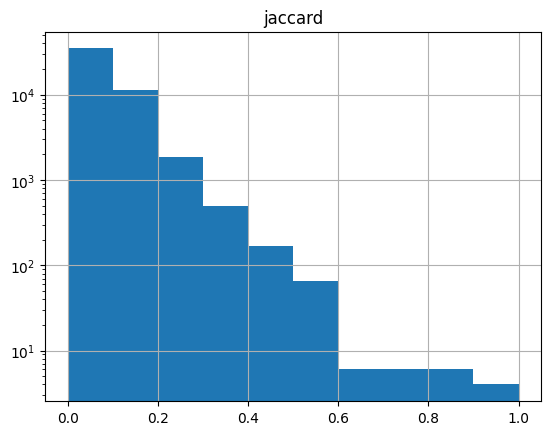

In [113]:
transform_matrix(S_mgrn).hist()
plt.yscale('log')

In [19]:
S_mgrn.loc[rxn_domains['MA'],rxn_domains['MA']].shape

(29, 29)

In [124]:
ma_stat = transform_matrix(S_mgrn.loc[rxn_domains['MA'],rxn_domains['MA']])

In [126]:
ma_stat[1]

bins
(-1e-06, 0.1]    0.492611
(0.1, 0.3]       0.435961
(0.3, 0.5]       0.066502
(0.5, 0.7]       0.002463
(0.7, 1.0]       0.002463
Name: proportion, dtype: float64

In [25]:
S_mgrn.loc[rxn_domains['SB'],rxn_domains['SB']].shape

(20, 20)

In [24]:
S_mgrn.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].shape

(14, 14)

In [20]:
print(f" max {max(S_mgrn.loc[rxn_domains['MA'],rxn_domains['MA']].describe().loc['50%'])}, min {min(S_mgrn.loc[rxn_domains['MA'],rxn_domains['MA']].describe().loc['50%'])}")

 max 0.1578947368421053, min 0.04166666666666663


In [22]:
print(f" max {max(S_mgrn.loc[rxn_domains['SB'],rxn_domains['SB']].describe().loc['50%'])}, min {min(S_mgrn.loc[rxn_domains['SB'],rxn_domains['SB']].describe().loc['50%'])}")

 max 0.12771739130434784, min 0.054090909090909134


In [23]:
print(f" max {max(S_mgrn.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].describe().loc['50%'])}, min {min(S_mgrn.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].describe().loc['50%'])}")

 max 0.15990566037735848, min 0.05646879756468798


<Axes: >

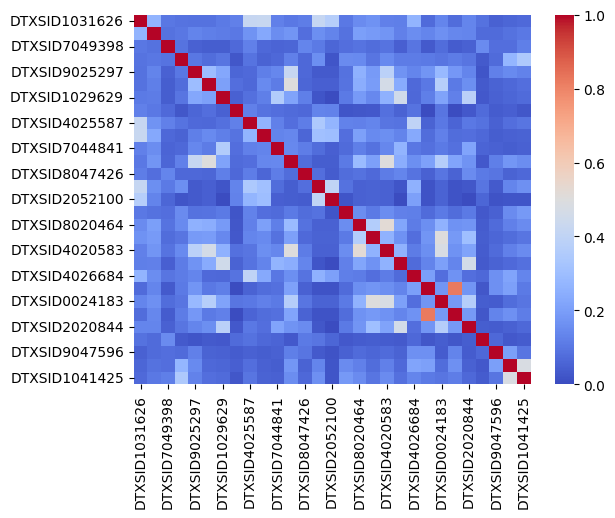

In [21]:
sns.heatmap(S_mgrn.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm')

## ToxPrints

In [26]:
txps = pd.read_excel(raw_dir/'toxprints-2024-11-27T17_02_57.xlsx')

/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [27]:
S_txp = (txps
 .set_index('DTXSID')
 .drop(['CASRN', 'Name', 'SMILES', 'DTXCID'], axis = 1)
 .pipe(lambda df : 1- pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index))
 .rename_axis(index=None, columns=None) 
)

<Axes: >

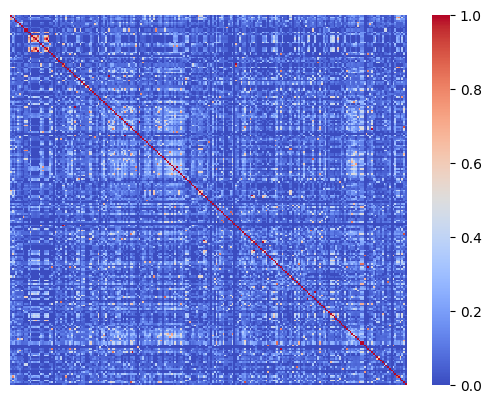

In [28]:
sns.heatmap(S_txp,cmap = 'coolwarm',xticklabels=False, yticklabels=False)

In [29]:
print(f" max {max(S_txp.describe().loc['50%'])}, min {min(S_txp.describe().loc['50%'])}")

 max 0.16666666666666663, min 0.0


In [127]:
ma_stat_txp = transform_matrix(S_txp.loc[rxn_domains['MA'],rxn_domains['MA']])

In [128]:
ma_stat_txp[1]

bins
(0.1, 0.3]       0.431034
(-1e-06, 0.1]    0.305419
(0.3, 0.5]       0.199507
(0.5, 0.7]       0.046798
(0.7, 1.0]       0.017241
Name: proportion, dtype: float64

In [129]:
ma_stat_wl= transform_matrix(p1.loc[rxn_domains['MA'],rxn_domains['MA']])
ma_stat_wl[1]

bins
(0.1, 0.3]       0.522167
(-1e-06, 0.1]    0.310345
(0.3, 0.5]       0.118227
(0.5, 0.7]       0.044335
(0.7, 1.0]       0.004926
Name: proportion, dtype: float64

In [30]:
print(f" max {max(S_txp.loc[rxn_domains['MA'],rxn_domains['MA']].describe().loc['50%'])}, min {min(S_txp.loc[rxn_domains['MA'],rxn_domains['MA']].describe().loc['50%'])}")

 max 0.3157894736842105, min 0.05555555555555558


In [32]:
print(f" max {max(S_txp.loc[rxn_domains['SB'],rxn_domains['SB']].describe().loc['50%'])}, min {min(S_txp.loc[rxn_domains['SB'],rxn_domains['SB']].describe().loc['50%'])}")

 max 0.25, min 0.0


In [33]:
print(f" max {max(S_txp.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].describe().loc['50%'])}, min {min(S_txp.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].describe().loc['50%'])}")

 max 0.1952380952380952, min 0.052631578947368474


<Axes: >

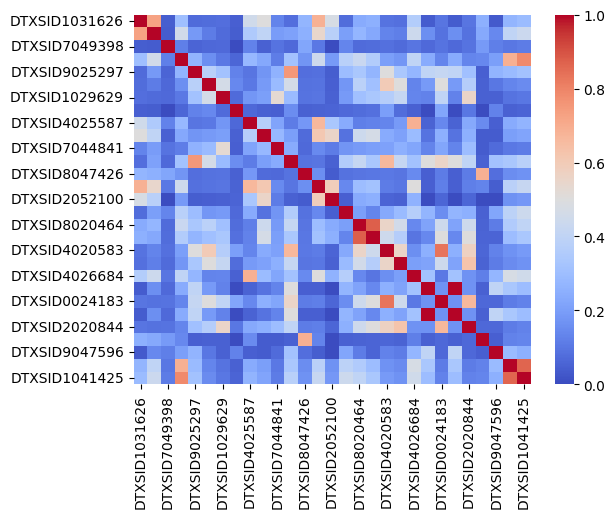

In [31]:
sns.heatmap(S_txp.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm')

In [48]:
p1.loc[['DTXSID5047035', 'DTXSID1041425'],['DTXSID5047035', 'DTXSID1041425'] ]

,DTXSID5047035,DTXSID1041425
DTXSID5047035,1.000000,0.538356
DTXSID1041425,0.538356,1.000000


In [36]:
S_txp.loc[['DTXSID2021159', 'DTXSID7026235'],['DTXSID2021159', 'DTXSID7026235'] ]

,DTXSID2021159,DTXSID7026235
DTXSID2021159,1.0,0.7
DTXSID7026235,0.7,1.0


In [35]:
import grakel
import networkx as nx

In [37]:
#| echo: false
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), atom_label = str(node_label))

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [38]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(llna['DTXSID'], llna['SMILES'])}

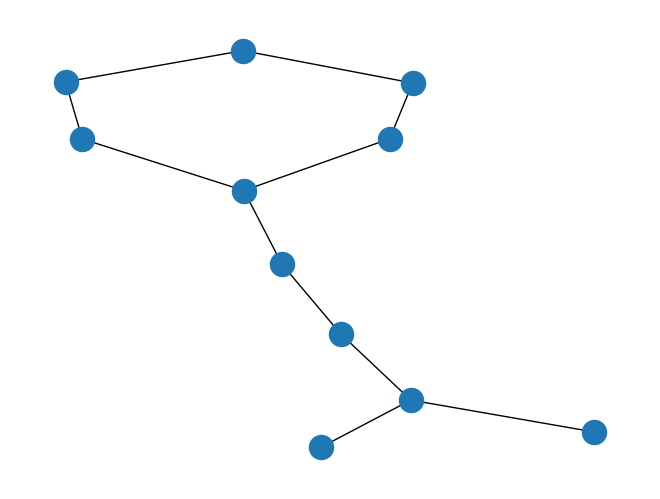

In [39]:
nx.draw(graphs['DTXSID1031626'])

In [40]:
grakel_graphs = grakel.graph_from_networkx(list(graphs.values()),node_labels_tag='atom_label') 



In [41]:


# Compute the WL kernel
wl_kernel = grakel.WeisfeilerLehman(base_graph_kernel=grakel.VertexHistogram,normalize=True)
kernel_matrix = wl_kernel.fit_transform(grakel_graphs)

In [42]:
p1 = pd.DataFrame(kernel_matrix, columns = graphs.keys(), index = graphs.keys())

p1

,DTXSID1031626,DTXSID4051879,DTXSID00231670,DTXSID7049398,DTXSID7026235,DTXSID5032523,DTXSID8026515,DTXSID5021881,DTXSID4021137,DTXSID9021138,...,DTXSID90225265,DTXSID5021332,DTXSID5046512,DTXSID7026156,DTXSID5047035,DTXSID1041425,DTXSID8049416,DTXSID3037757,DTXSID0021969,DTXSID8021438
DTXSID1031626,1.000000,0.077968,0.364646,0.139443,0.260956,0.391773,0.048977,0.000000,0.282634,0.236228,...,0.317669,0.040916,0.000000,0.225234,0.070186,0.106904,0.478894,0.035021,0.285240,0.015749
DTXSID4051879,0.077968,1.000000,0.135692,0.228315,0.027566,0.011254,0.231663,0.148873,0.000000,0.000000,...,0.006421,0.029775,0.163082,0.029503,0.555437,0.393835,0.011122,0.596341,0.069190,0.000000
DTXSID00231670,0.364646,0.135692,1.000000,0.157165,0.281284,0.296654,0.083343,0.025318,0.253293,0.263117,...,0.245715,0.063296,0.027735,0.250873,0.130292,0.148842,0.312099,0.084515,0.372621,0.014618
DTXSID7049398,0.139443,0.228315,0.157165,1.000000,0.084515,0.011501,0.091060,0.030429,0.000000,0.000000,...,0.019687,0.121716,0.033333,0.050252,0.205527,0.253421,0.011367,0.125015,0.094281,0.035136
DTXSID7026235,0.260956,0.027566,0.281284,0.084515,1.000000,0.272166,0.153919,0.000000,0.211339,0.193022,...,0.277316,0.038576,0.000000,0.246329,0.024815,0.037796,0.278589,0.019811,0.278887,0.044544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID1041425,0.106904,0.393835,0.148842,0.253421,0.037796,0.015430,0.122169,0.081650,0.000000,0.000000,...,0.008805,0.040825,0.089443,0.040452,0.538356,1.000000,0.015250,0.272554,0.094868,0.000000
DTXSID8049416,0.478894,0.011122,0.312099,0.011367,0.278589,0.494152,0.018631,0.000000,0.344785,0.287554,...,0.409516,0.000000,0.000000,0.277599,0.010012,0.015250,1.000000,0.007993,0.361682,0.000000
DTXSID3037757,0.035021,0.596341,0.084515,0.125015,0.019811,0.008088,0.294557,0.171184,0.000000,0.000000,...,0.004615,0.000000,0.187523,0.014135,0.646939,0.272554,0.007993,1.000000,0.033150,0.012354
DTXSID0021969,0.285240,0.069190,0.372621,0.094281,0.278887,0.317168,0.028975,0.000000,0.265228,0.242241,...,0.299305,0.032275,0.000000,0.277161,0.062284,0.094868,0.361682,0.033150,1.000000,0.000000


In [43]:
print(f" max {max(p1.loc[rxn_domains['MA'],rxn_domains['MA']].describe().loc['50%'])}, min {min(p1.loc[rxn_domains['MA'],rxn_domains['MA']].describe().loc['50%'])}")

 max 0.24152294576982397, min 0.043301270189221926


In [45]:
print(f" max {max(p1.loc[rxn_domains['SB'],rxn_domains['SB']].describe().loc['50%'])}, min {min(p1.loc[rxn_domains['SB'],rxn_domains['SB']].describe().loc['50%'])}")

 max 0.21935419124879774, min 0.014815910002183285


In [46]:
print(f" max {max(p1.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].describe().loc['50%'])}, min {min(p1.loc[rxn_domains['Acyl'],rxn_domains['Acyl']].describe().loc['50%'])}")

 max 0.3995672410614939, min 0.05506926876544836


In [47]:
print(f" max {max(p1.describe().loc['50%'])}, min {min(p1.describe().loc['50%'])}")

 max 0.33709611339431655, min 0.012606383887263007


<Axes: >

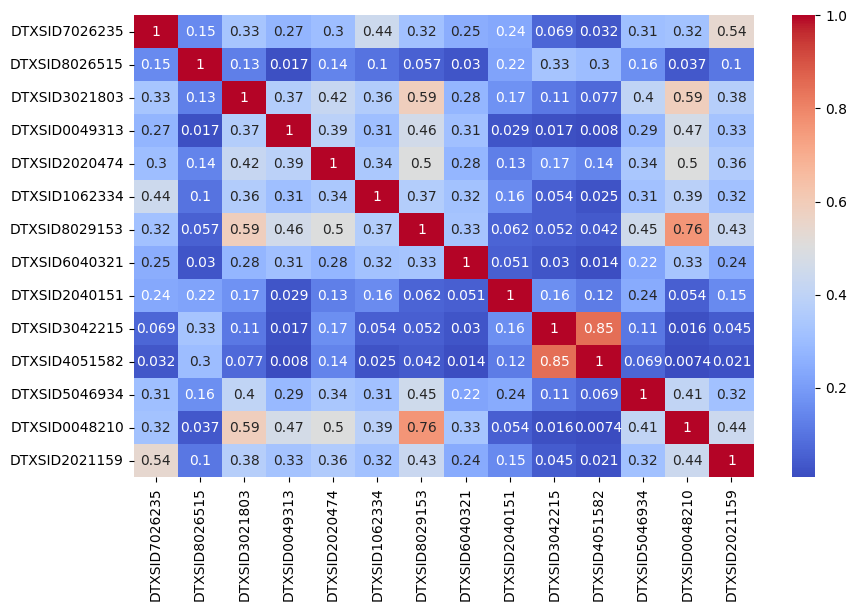

In [30]:
plt.figure(figsize = (10,6))
sns.heatmap(p1.loc[rxn_domains['Acyl'],rxn_domains['Acyl']], cmap = 'coolwarm', annot = True)

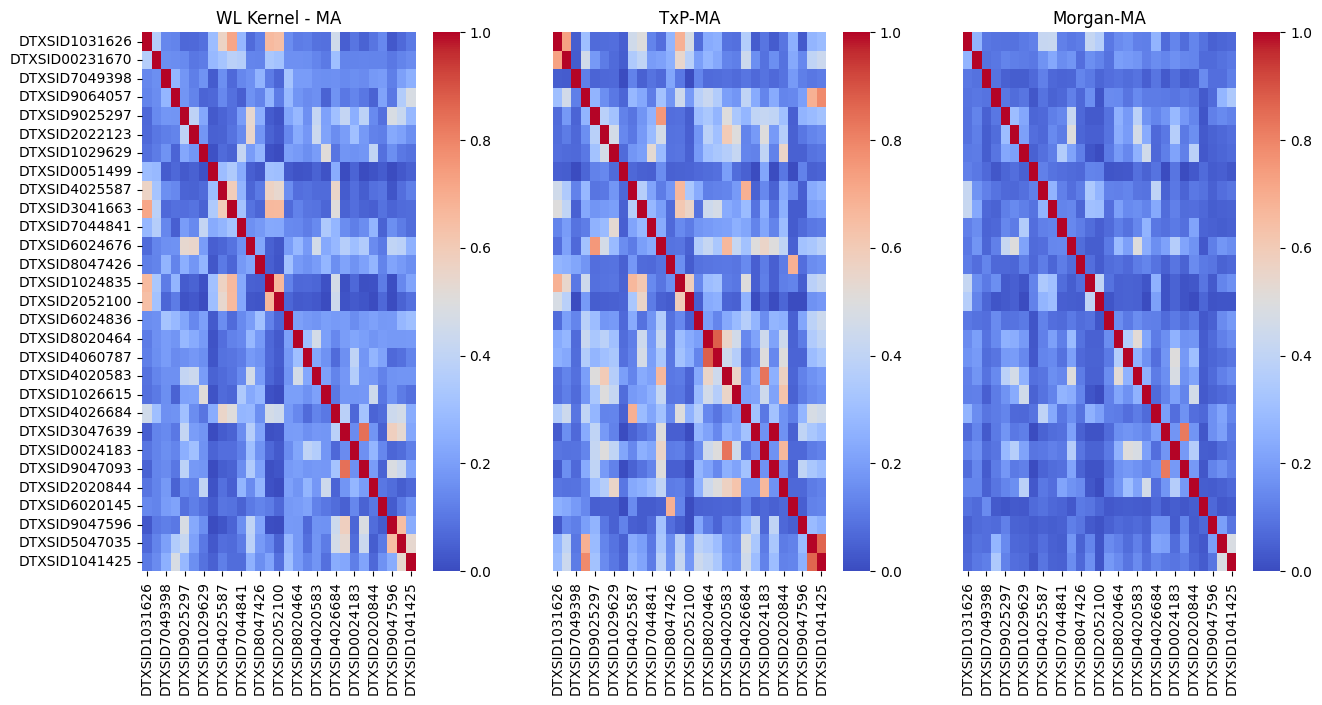

In [76]:
f, ax = plt.subplots(1,3, figsize=(15,7))
sns.heatmap(p1.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm',  ax= ax[0])
ax[0].set_title("WL Kernel - MA")
sns.heatmap(S_txp.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm', ax= ax[1], yticklabels=False)
ax[1].set_title("TxP-MA")
sns.heatmap(S_mgrn.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm',  ax= ax[2],yticklabels=False)
ax[2].set_title("Morgan-MA")
f.savefig(figures_dir/'llna_sim_MA.png', dpi = 300, bbox_inches='tight')

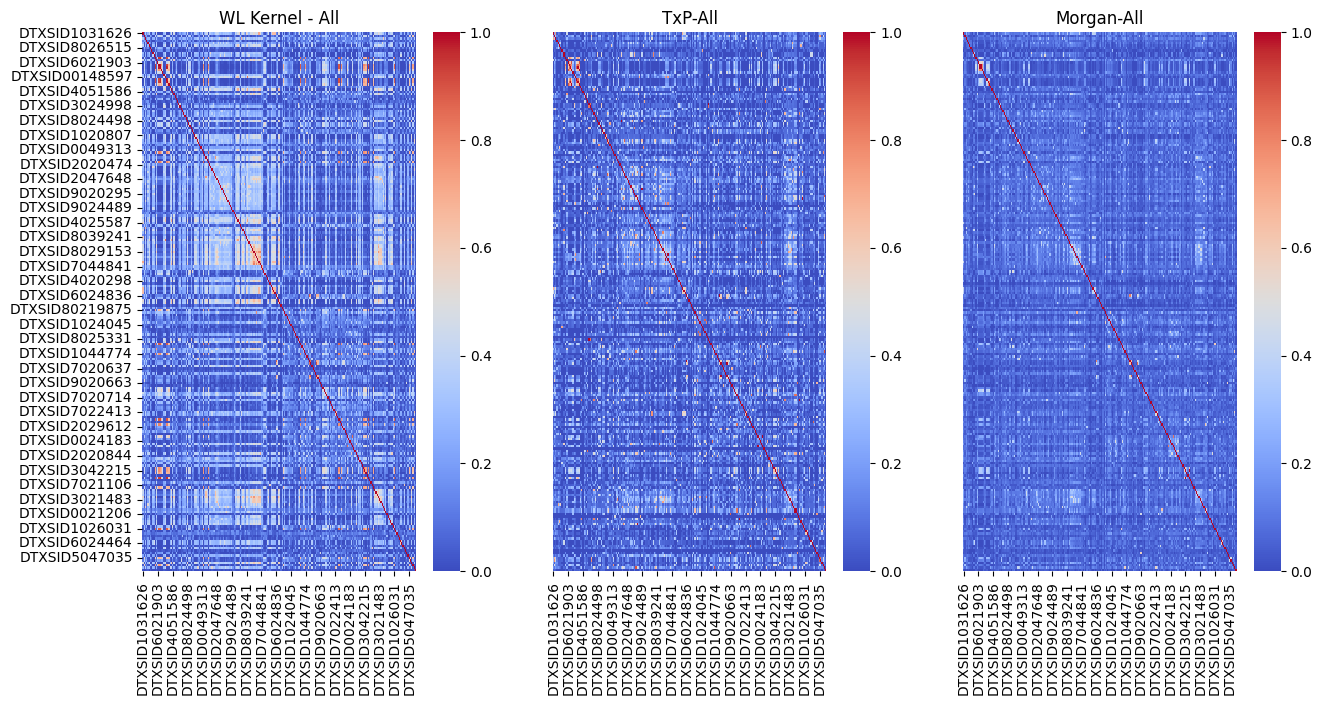

In [75]:
#graph
f, ax = plt.subplots(1,3, figsize=(15,7))
sns.heatmap(p1,cmap = 'coolwarm',  ax= ax[0])
ax[0].set_title("WL Kernel - All")
sns.heatmap(S_txp, cmap = 'coolwarm', ax= ax[1], yticklabels=False)
ax[1].set_title("TxP-All")
sns.heatmap(S_mgrn,cmap = 'coolwarm',  ax= ax[2],yticklabels=False)
ax[2].set_title("Morgan-All")
f.savefig(figures_dir/'llna_sim_all.png', dpi = 300, bbox_inches='tight')

In [33]:
p1

,DTXSID1031626,DTXSID4051879,DTXSID00231670,DTXSID7049398,DTXSID7026235,DTXSID5032523,DTXSID8026515,DTXSID5021881,DTXSID4021137,DTXSID9021138,...,DTXSID90225265,DTXSID5021332,DTXSID5046512,DTXSID7026156,DTXSID5047035,DTXSID1041425,DTXSID8049416,DTXSID3037757,DTXSID0021969,DTXSID8021438
DTXSID1031626,1.000000,0.077968,0.364646,0.139443,0.260956,0.391773,0.048977,0.000000,0.282634,0.236228,...,0.317669,0.040916,0.000000,0.225234,0.070186,0.106904,0.478894,0.035021,0.285240,0.015749
DTXSID4051879,0.077968,1.000000,0.135692,0.228315,0.027566,0.011254,0.231663,0.148873,0.000000,0.000000,...,0.006421,0.029775,0.163082,0.029503,0.555437,0.393835,0.011122,0.596341,0.069190,0.000000
DTXSID00231670,0.364646,0.135692,1.000000,0.157165,0.281284,0.296654,0.083343,0.025318,0.253293,0.263117,...,0.245715,0.063296,0.027735,0.250873,0.130292,0.148842,0.312099,0.084515,0.372621,0.014618
DTXSID7049398,0.139443,0.228315,0.157165,1.000000,0.084515,0.011501,0.091060,0.030429,0.000000,0.000000,...,0.019687,0.121716,0.033333,0.050252,0.205527,0.253421,0.011367,0.125015,0.094281,0.035136
DTXSID7026235,0.260956,0.027566,0.281284,0.084515,1.000000,0.272166,0.153919,0.000000,0.211339,0.193022,...,0.277316,0.038576,0.000000,0.246329,0.024815,0.037796,0.278589,0.019811,0.278887,0.044544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID1041425,0.106904,0.393835,0.148842,0.253421,0.037796,0.015430,0.122169,0.081650,0.000000,0.000000,...,0.008805,0.040825,0.089443,0.040452,0.538356,1.000000,0.015250,0.272554,0.094868,0.000000
DTXSID8049416,0.478894,0.011122,0.312099,0.011367,0.278589,0.494152,0.018631,0.000000,0.344785,0.287554,...,0.409516,0.000000,0.000000,0.277599,0.010012,0.015250,1.000000,0.007993,0.361682,0.000000
DTXSID3037757,0.035021,0.596341,0.084515,0.125015,0.019811,0.008088,0.294557,0.171184,0.000000,0.000000,...,0.004615,0.000000,0.187523,0.014135,0.646939,0.272554,0.007993,1.000000,0.033150,0.012354
DTXSID0021969,0.285240,0.069190,0.372621,0.094281,0.278887,0.317168,0.028975,0.000000,0.265228,0.242241,...,0.299305,0.032275,0.000000,0.277161,0.062284,0.094868,0.361682,0.033150,1.000000,0.000000


In [34]:
from collections import Counter

In [35]:
def weisfeiler_lehman_step(G):
    new_labels = {}
    for node in G.nodes():
        neighbors_labels = [G.nodes[neighbor]['atom_label'] for neighbor in G.neighbors(node)]
        new_label = hash((G.nodes[node]['atom_label'], tuple(sorted(neighbors_labels))))
        new_labels[node] = new_label
    nx.set_node_attributes(G, new_labels, 'atom_label')

def weisfeiler_lehman_hash(G, n_iter=5):
    for _ in range(n_iter):
        weisfeiler_lehman_step(G)
    return Counter([G.nodes[node]['atom_label'] for node in G.nodes()])

def wl_kernel_normalized(graphs, n_iter=2):
    wl_hashes = [weisfeiler_lehman_hash(G, n_iter) for G in graphs]
    n = len(graphs)
    kernel_matrix = np.zeros((n, n))
    normalized_matrix = np.zeros_like(kernel_matrix)

    for i in range(n):
        for j in range(n):
            kernel_matrix[i, j] = sum((wl_hashes[i] & wl_hashes[j]).values())

    # Normalize the kernel matrix
    for i in range(n):
        for j in range(n):
            norm_factor = np.sqrt(kernel_matrix[i, i] * kernel_matrix[j, j])
            normalized_matrix[i, j] = kernel_matrix[i, j] / norm_factor if norm_factor != 0 else 0
    return normalized_matrix

In [36]:
km_norm = wl_kernel_normalized(list(graphs.values()), n_iter=2)

In [37]:
p2 = pd.DataFrame(km_norm, columns = graphs.keys(), index = graphs.keys())

Text(0.5, 1.0, 'WL Kernel - MA manual')

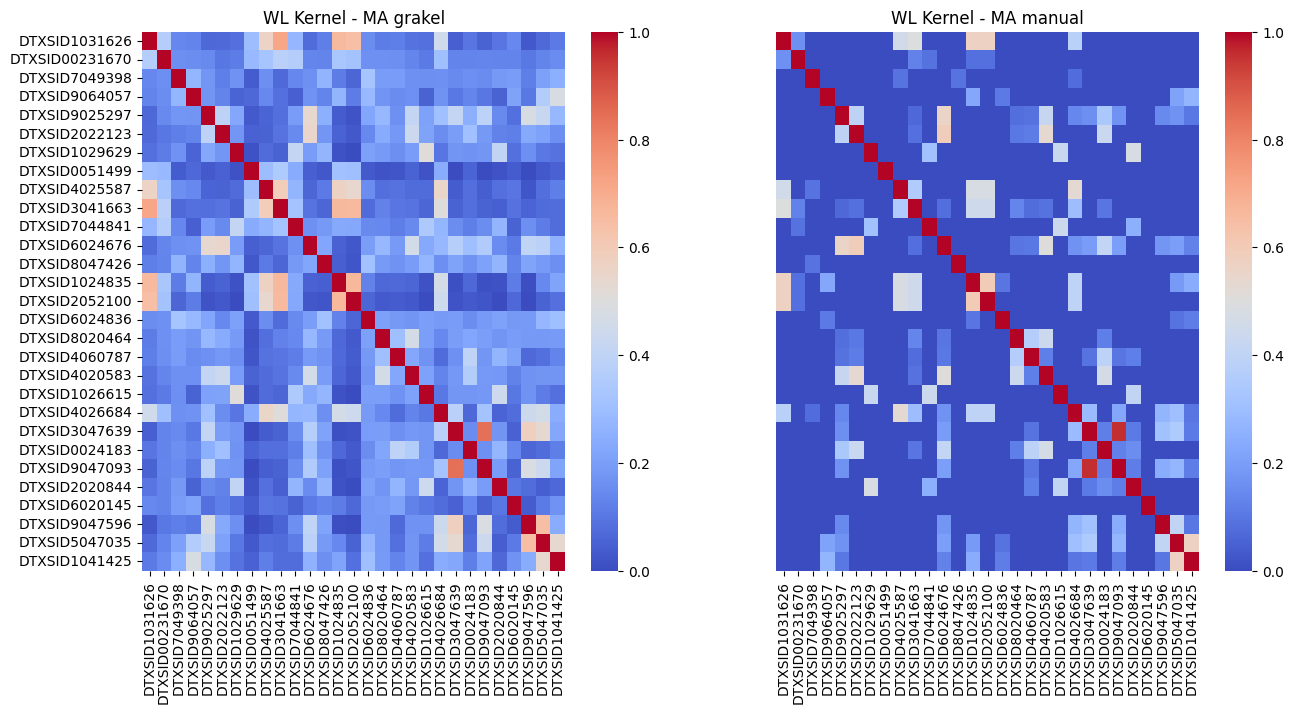

In [38]:
f, ax = plt.subplots(1,2, figsize=(15,7))
sns.heatmap(p1.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm',  ax= ax[0])
ax[0].set_title("WL Kernel - MA grakel")
sns.heatmap(p2.loc[rxn_domains['MA'],rxn_domains['MA']], cmap = 'coolwarm', ax= ax[1], yticklabels=False)
ax[1].set_title("WL Kernel - MA manual")

# Metabolic profile of LLNA data

In [41]:
times = pd.read_excel(external_dir/'JRC_out.xlsx')

In [42]:
times = (times
 .assign(Parent = lambda x: x['Chemical name'].ffill())
)

In [43]:
times = (times
 .assign(Parent_id = lambda df: df['Chemical name'].apply(
        lambda x: 'Parent' if isinstance(x, str)  else x
    ))
)

In [44]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key


In [45]:
newlst = []

# Sort the DataFrame by 'Parent' and any other relevant column, such as 'Level of generation'
times = times.sort_values(by=['Parent', 'Level of generation']).reset_index(drop=True)

# Iterate over each group
for i, group in times.groupby('Parent'):
    subset = group[['Parent', 'Parent_id']]
    # Define a counter for generating unique identifiers
    counter = 1
    # Iterate over rows in the subset
    for index, row in subset.iterrows():
        if row['Parent_id'] == 'Parent':
            newlst.append(row['Parent'])  # Use the parent ID as is
        else:
            # Append with a unique identifier based on the counter
            newlst.append(row['Parent'] + '_m_' + str(counter))
            # Increment the counter
            counter += 1

In [46]:
len(newlst)

2830

In [47]:
times.shape

(2830, 22)

In [48]:
times['ID'] = newlst

In [49]:
times

,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,skin_sens_exp,Observed map/metabolite,Transformation name,Transformation No,...,Transformation type,Transformation probability,Used probability,Quantity of metabolite,Total quantity of metabolite,Number of repetitions,Status,Parent,Parent_id,ID
0,1,0,-,NaN,DTXSID00148597,ClCc1ccc2ccc3cccc4ccc1c2c34,Strong sensitiser,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00250,0.00250,1,Strong sensitizer,DTXSID00148597,Parent,DTXSID00148597
1,2,1,1,NaN,NaN,[Pr]NCc1ccc2ccc3cccc4ccc1c2c34,NaN,NaN,SN2|Nucleophilic Substitution on Benzilyc Carb...,54,...,[Strong ActiveAdduct Formation],0.99,0.5675,0.56750,0.56750,1,Protein conjugate,DTXSID00148597,NaN,DTXSID00148597_m_1
2,3,1,1,NaN,NaN,Cl,NaN,NaN,SN2|Nucleophilic Substitution on Benzilyc Carb...,54,...,[Strong ActiveAdduct Formation],0.99,0.5675,0.56750,0.99750,2,Inorganic chemical,DTXSID00148597,NaN,DTXSID00148597_m_2
3,4,1,1,NaN,NaN,NC(CCC(=O)NC(CSCc1ccc2ccc3cccc4ccc1c2c34)C(=O)...,NaN,NaN,Glutathione Conjugation|Glutathione Conjugatio...,371,...,[phase II],0.75,0.4300,0.43000,0.43000,1,Eliminated by Phase II,DTXSID00148597,NaN,DTXSID00148597_m_3
4,5,1,1,NaN,NaN,Cl,NaN,NaN,Glutathione Conjugation|Glutathione Conjugatio...,371,...,[phase II],0.75,0.4300,0.43000,0.99750,2,Inorganic chemical,DTXSID00148597,NaN,DTXSID00148597_m_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,6,1,2,NaN,NaN,CCC=CC=CC(=O)OC1C(O)C(O)C(O)C(C(O)=O)O1,NaN,NaN,O-Glucuronidation|Glucuronidation of Carboxyli...,379,...,[phase II],0.70,0.4550,0.06825,0.26060,2,Eliminated by Phase II,DTXSID9064057,NaN,DTXSID9064057_m_3
2826,3,1,1,NaN,NaN,CCC=CC(CC=O)S[Pr],NaN,NaN,"Michael Addition|Michael Addition on alpha,bet...",132,...,[Strong ActiveAdduct Formation],0.99,0.5024,0.42710,0.42710,1,Protein conjugate,DTXSID9064057,NaN,DTXSID9064057_m_4
2827,4,1,1,NaN,NaN,CCC=CC=CC(O)=O,NaN,NaN,Aldehyde Oxidation,310,...,[phase I],0.98,0.4974,0.03805,0.05155,2,Non-sensitizer,DTXSID9064057,NaN,DTXSID9064057_m_5
2828,7,2,4,NaN,NaN,CCC=CC=CC(=O)NCC(O)=O,NaN,NaN,Glycine Conjugation|Glycine Conjugation of Car...,378,...,[phase II],0.70,0.4550,0.19240,0.26060,2,Eliminated by Phase II,DTXSID9064057,NaN,DTXSID9064057_m_6


In [51]:
inchi_keys = {}
errors = []
for k,v in zip(times['ID'], times['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X


[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected

[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected

[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected

[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Accepted unusual valence(s): Pr(1); Metal was disconnected; Proton(s) added/removed; Omitted undefined stereo

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: Omitted undefined stereo

[18:36:52] WARNING: O

In [52]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [53]:

times = pd.merge(times, df_inchi, on = 'ID', how = 'left')

In [54]:
times[['ID of metabolite', 'Level of generation', 'Predecessor ID','Chemical name', 'SMILES','Parent', 'ID']].head(3)

,ID of metabolite,Level of generation,Predecessor ID,Chemical name,SMILES,Parent,ID
0,1,0,-,DTXSID00148597,ClCc1ccc2ccc3cccc4ccc1c2c34,DTXSID00148597,DTXSID00148597
1,2,1,1,NaN,[Pr]NCc1ccc2ccc3cccc4ccc1c2c34,DTXSID00148597,DTXSID00148597_m_1
2,3,1,1,NaN,Cl,DTXSID00148597,DTXSID00148597_m_2


In [55]:
times.columns

Index(['ID of metabolite', 'Level of generation', 'Predecessor ID', 'CAS',
       'Chemical name', 'SMILES', 'skin_sens_exp', 'Observed map/metabolite',
       'Transformation name', 'Transformation No', 'Transformation ID',
       'Transformation probability group', 'Transformation expert group',
       'Transformation type', 'Transformation probability', 'Used probability',
       'Quantity of metabolite', 'Total quantity of metabolite',
       'Number of repetitions', 'Status', 'Parent', 'Parent_id', 'ID',
       'INCHI_KEY'],
      dtype='object')

In [56]:
times1 = (times
 .rename(columns=lambda col: col.replace(' ', '_'))
 .assign(transformation = lambda df : df['Transformation_name'].apply(
        lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
    )) 
 .filter(items = ['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',  'Chemical_name', 'SMILES',  'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation'])
)


In [58]:
times1.to_csv(raw_dir/'times1.csv')

In [282]:
transformation_types = times1['transformation'].unique().tolist()

In [283]:
transformation_types = transformation_types[1:]

In [284]:
len(transformation_types)

82

In [285]:
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024))
    else:
        return None


In [286]:
edges = times1[times1['Predecessor_ID'] != '-']

In [287]:
times1['Fingerprint'] = times1['SMILES'].apply(generate_fingerprint)

[16:17:02] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCCCOC(=O)c1cc([O.])c(O)c(O)c1
[16:17:02] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCCCOC(=O)c1cc([O.])c(O)c(O)c1' for input: 'CCCCCCCCCCCCOC(=O)c1cc([O.])c(O)c(O)c1'
[16:17:03] SMILES Parse Error: syntax error while parsing: CCCOC(=O)c1cc([O.])c(O)c(O)c1
[16:17:03] SMILES Parse Error: Failed parsing SMILES 'CCCOC(=O)c1cc([O.])c(O)c(O)c1' for input: 'CCCOC(=O)c1cc([O.])c(O)c(O)c1'
[16:17:04] SMILES Parse Error: syntax error while parsing: Cc1ccc(S(=O)(=O)[N-](.[Na+])Cl)cc1
[16:17:04] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(S(=O)(=O)[N-](.[Na+])Cl)cc1' for input: 'Cc1ccc(S(=O)(=O)[N-](.[Na+])Cl)cc1'
[16:17:04] SMILES Parse Error: syntax error while parsing: Cc1ccc(S([N.])(=O)=O)cc1
[16:17:04] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(S([N.])(=O)=O)cc1' for input: 'Cc1ccc(S([N.])(=O)=O)cc1'
[16:17:04] SMILES Parse Error: syntax error while parsing: [O.]c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl
[16:17:04] SMIL

In [288]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [289]:
transformation_index = {t: i for i, t in enumerate(transformation_types)}

In [316]:
# Group data by 'Parent'
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}

In [317]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"


In [318]:
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['Fingerprint'],
            ID = row['ID']
        )
    
    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    # Store the graph with the Parent as the key
    graph_dict[parent] = G

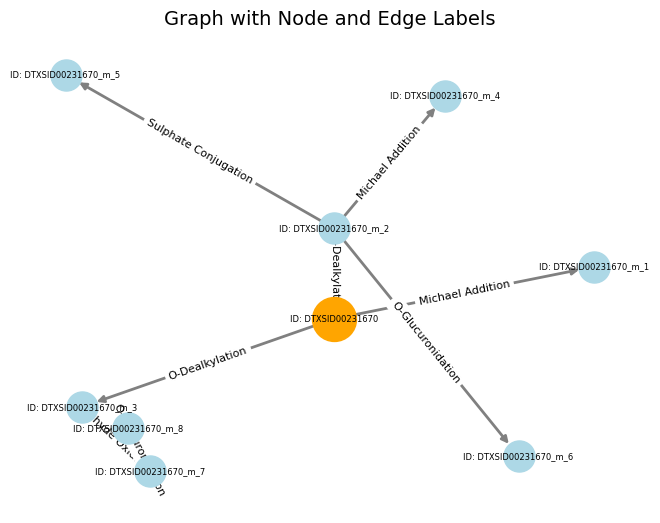

In [320]:
# Access a specific graph
parent_id = "DTXSID00231670"
G = graph_dict[parent_id]


pos = nx.spring_layout(G, k=0.5, seed=42)
# Visualize the graph (optional)
nx.draw(
    G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=6, edge_color='gray', width=2
)

# Draw node labels using a 'label' attribute
node_labels = nx.get_node_attributes(G, 'label')  # Ensure nodes have a 'label' attribute
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6)

# Draw edge labels (ensure edges have a 'transformation_type' or similar attribute)
edge_labels = nx.get_edge_attributes(G, 'transformation_type')  # Ensure edges have this attribute
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Make parent nodes stand out (e.g., larger size, different color)
parent_nodes = [node for node, label in node_labels.items() if '_m_' not in label]# Identify parent nodes by condition
nx.draw_networkx_nodes(G, pos, nodelist=parent_nodes, node_color='orange', node_size=1000)

# Optionally, adjust layout with more manual control to avoid overlap
# You can tweak 'pos' manually if you know the specific positions
# Example: pos['Parent'] = [0, 0]  # This sets the 'Parent' node to the center

plt.title("Graph with Node and Edge Labels", fontsize=14)
plt.axis('off')  # Turn off the axis to make the graph clearer
plt.show()

In [387]:
graph_dict['DTXSID00148597']
# Inspect nodes and edges
#print(f"Nodes for {'DTXSID00148597'}:", graphs['DTXSID00148597'].nodes(data=True))
#print(f"Edges for {'DTXSID00148597'}:",graphs['DTXSID00148597'].edges(data=True))

In [388]:
my_graphs = list(graph_dict.values())

In [438]:
import hashlib

In [442]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict2 = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['Fingerprint'],
            ID = row['ID']
        )
   # Convert bit vector labels to strings
    for node in G.nodes():
        fingerprint_tuple = str(G.nodes[node]['fingerprint'])
        
        G.nodes[node]['label'] = fingerprint_tuple

    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    
    
    # Store the grakel graph in the dictionary
    graph_dict2[parent] = G


In [443]:
my_graphs = list(graph_dict2.values())

In [444]:

my_grakel_graphs = grakel.graph_from_networkx(my_graphs, node_labels_tag='label')  # Use 'fingerprint' for node labels
    

                  
             


In [445]:
wl_kernel = grakel.WeisfeilerLehman(base_graph_kernel=grakel.VertexHistogram,normalize=True)
kernel_scores = pd.DataFrame(wl_kernel.fit_transform(my_grakel_graphs))

In [446]:
kernel_scores

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
0,1.000000,0.571429,0.666667,0.0,0.0,0.0,0.000000,0.549011,0.000000,0.000,...,0.590281,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.571429,1.000000,0.666667,0.0,0.0,0.0,0.000000,0.549011,0.000000,0.000,...,0.590281,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,0.666667,1.000000,0.0,0.0,0.0,0.000000,0.640513,0.000000,0.000,...,0.688662,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.237791,0.038278,0.316228,0.000,...,0.148159,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000,...,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,...,0.000000,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
218,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.375,...,0.000000,0.0,0.375,0.0,0.0,0.0,1.0,0.0,0.0,0.0
219,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,...,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
220,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,...,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
